In [57]:
%matplotlib inline
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# Import Data

In [295]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
gs=pd.read_csv("gender_submission.csv")

I like to look at the _tail_, rather than the _head_, of a df, since it gives you the number of instances as well as a peak at the data

# Initial analysis

## Data structure

In [59]:
train.tail(2)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The train data set has missing values. In particular, the cabin data is particularly sparse.

In [6]:
train.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

So _Age_, _Cabin_, and _Embarked_ features have missing instances. How many rows have missing data?

In [7]:
train.shape[0]-train.dropna().shape[0]

708

We want to model survival or fatality by building a binary classifier. How many people died on the titanic in our train set?

In [8]:
print("Died {} ({:.0f}%)\nSurvived: {} ({:.0f}%)".format(len(train[train["Survived"]==0]),
                                                (len(train[train["Survived"]==0])/len(train))*100,
                                                len(train[train["Survived"]==1]),
                                               (len(train[train["Survived"]==1])/len(train))*100))


Died 549 (62%)
Survived: 342 (38%)


## Pair Plot

Our train set is biased by 2:1 for deaths vs survival. Lets do a pairwise plot using only rows with full instances with no NAs, and only numeric values

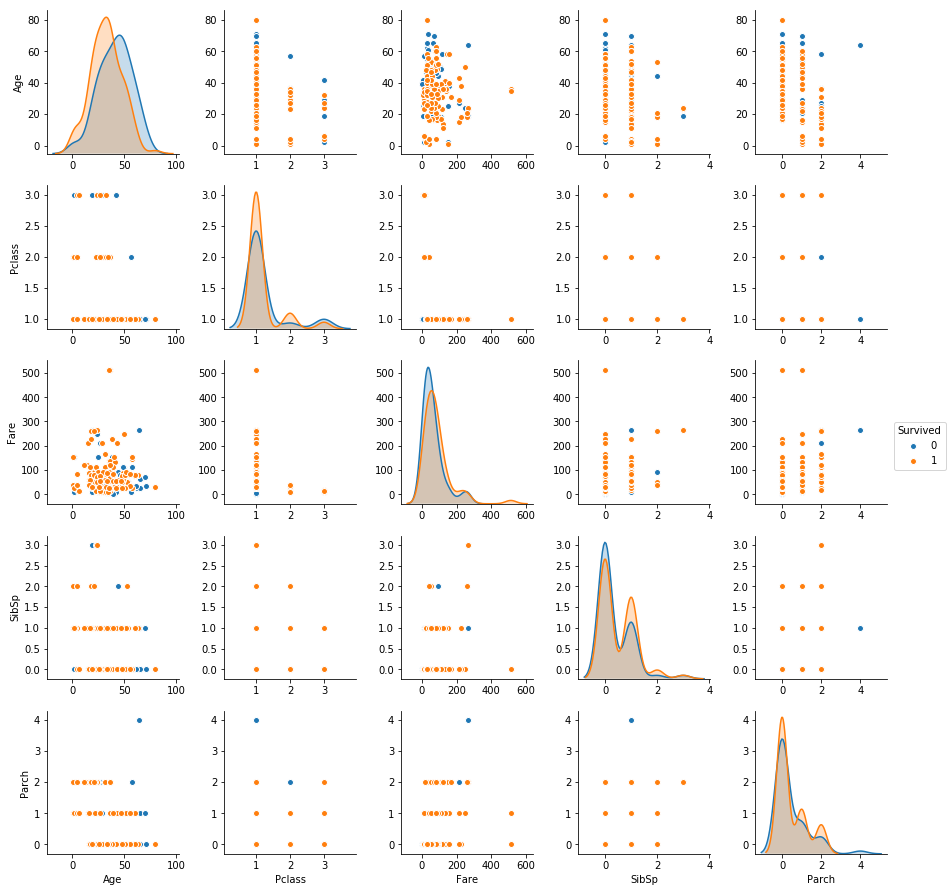

In [9]:
sns.pairplot(train.dropna(),hue="Survived",vars=["Age","Pclass","Fare","SibSp","Parch"],diag_kind="kde",diag_kws=dict(shade=True))

## Features

### Gender

In [10]:
def bar_by_feat(dataframe,feat1,feat2):
    """Plot two feature 1 against feature 2 of the data frame"""
    positive=dataframe[dataframe[feat1]==1][feat2].value_counts()
    negative=dataframe[dataframe[feat1]==0][feat2].value_counts()
    newdf=pd.DataFrame([positive,negative])
    newdf.index=["positive","negative"]
    newdf.plot(kind='bar',stacked=True,figsize=(4,2),alpha=0.6,width=0.2,fontsize=12)
    

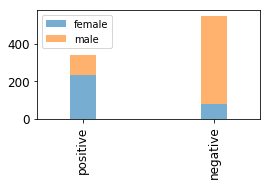

In [11]:
bar_by_feat(train,"Survived","Sex")

It is evident that you are more likely to survive if female.

### Age

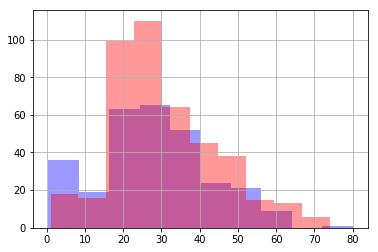

In [12]:
train.loc[train["Survived"]==1,"Age"].hist(alpha=0.4,color="blue")
train.loc[train["Survived"]==0,"Age"].hist(alpha=0.4,color="red")

It appears being in your mid 20s is not good for your survival chances!

### Fare

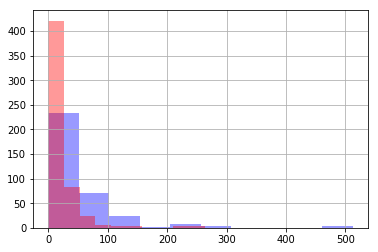

In [13]:
train.loc[train["Survived"]==1,"Fare"].hist(alpha=0.4,color="blue")
train.loc[train["Survived"]==0,"Fare"].hist(alpha=0.4,color="red")

Clearly the price you pay greatly influences your chance of surivial. At the extreme high prices, you survive.

The fares are clearly positively skewed. I may need to play with that later

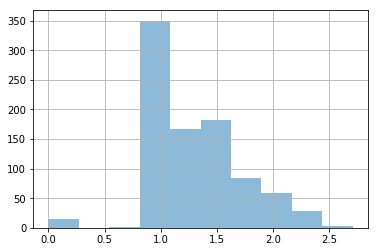

In [52]:
#np.log(train.loc[train["Fare"]!=0.0]).hist(alpha=0.4,color="blue")
#(np.log((train["Fare"]+1))).hist(alpha=0.7)
(np.log10((train["Fare"]+1))).hist(alpha=0.5)
#((train["Fare"])).hist()
#(((train["Fare"])**(1/3))).hist(alpha=0.5)

### Pclass

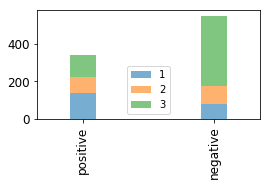

In [53]:
bar_by_feat(train,"Survived","Pclass")

Cearly most passengers are in 3rd class and most will die. 2/3 first class passengers will survive

In [55]:
for pclass in train["Pclass"].unique():
    died=train.loc[(train["Pclass"] ==pclass) & (train["Survived"] == 0), "Pclass"].shape[0]
    diedpcnt=(died/train.loc[train["Pclass"]==pclass].shape[0])*100
    survived=train.loc[(train["Pclass"] ==pclass) & (train["Survived"] == 1), "Pclass"].shape[0]
    survivedpcnt=(survived/train.loc[train["Pclass"]==pclass].shape[0])*100
    print("Class {}: {} ({:.0f}%) Survived, {} ({:.0f}%) Died".format(pclass,survived,survivedpcnt,died,diedpcnt))

Class 3: 119 (24%) Survived, 372 (76%) Died
Class 1: 136 (63%) Survived, 80 (37%) Died
Class 2: 87 (47%) Survived, 97 (53%) Died


### SibSp

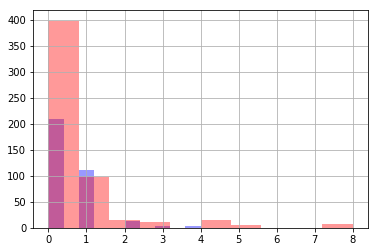

In [56]:
train.loc[train["Survived"]==1,"SibSp"].hist(alpha=0.4,color="blue")
train.loc[train["Survived"]==0,"SibSp"].hist(alpha=0.4,color="red")

### Parch

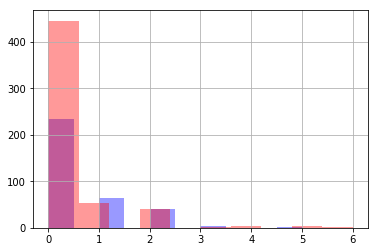

In [193]:
train.loc[train["Survived"]==1,"Parch"].hist(alpha=0.4,color="blue")
train.loc[train["Survived"]==0,"Parch"].hist(alpha=0.4,color="red")

# Conversion of catagorical data

In order to build a classifier, we are going to have to convert our catagorical features (sex,ticket,embarked) to vectors.

## Embarked

In [286]:
for i in train.select_dtypes(include=['object']).columns:
    print("{}: {} values, {} unique".format(i,len(train[i]),len(train[i].unique())))

Name: 891 values, 891 unique
Sex: 891 values, 2 unique
Ticket: 891 values, 681 unique
Cabin: 891 values, 148 unique
Embarked: 891 values, 4 unique


The name, ticket and cabin variables have many values. For my first model, I will exclude these. I shall only include "Sex" and "Embarked" of the catagorical values in the model. For this I will need to convert them to floating point values

In [303]:
train["Embarked"].isnull().sum()

2

In [296]:
train["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

First, lets fill in the 2 nans with S, the most common embark point

In [304]:
train["Embarked"].fillna(value="S",inplace=True)

In [308]:
new_embarked=pd.get_dummies(train['Embarked'],prefix='Embarked')

In [309]:
train = pd.concat([train,new_embarked],axis=1)
train.drop('Embarked',axis=1,inplace=True)

## Sex

In [310]:
train["Sex"].unique()

array(['male', 'female'], dtype=object)

In [312]:
train["Sex"]=train["Sex"].replace(to_replace='male',value=0)
train["Sex"]=train["Sex"].replace(to_replace='female',value=1)


I am going to test a few different algorithms, using a subset of the data. I expect these to be underfitted, since I have done litte feature engineering up to this point. Iniitally, I will test a few classifiers using _scikitlearn_ to get a baseline accuracy. I will then do some feature engineering to improve the models. 

# Baseline models

In [313]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked_C', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')

In [314]:
features=["Survived","Pclass","Sex","Age","SibSp","Parch","Fare","Embarked_C","Embarked_Q","Embarked_S"]

In [315]:
X=train[features].dropna().drop("Survived",axis=1)
y=train[features].dropna()["Survived"]
print(len(X),len(y))
print(y.mean())

714 714
0.406162464986


So 41% of our input data for the first model have value==1 (ie, they survived). This is fair reflection of the original set, which has a 38% survival rate. For the current train set, if we predict 1 for every instance, we would be correct 40% of the time.

I am going to further split our train data set into a train and test set, so we can test our model properly, since the _test_ set provided by Kaggle does not have an answer we can check so we cannot validate our model against it

In [316]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(len(y_train))
print(len(y_test))
print(y_train.mean())
print(y_test.mean())

535
179
0.416822429907
0.374301675978


In [317]:
scores={}

### Gaussian Naive Bayes

The first method I will trial is Gaussian Naive Bayes

In [318]:
from sklearn.naive_bayes import GaussianNB

In [319]:
gnb = GaussianNB()
gnb=gnb.fit(X_train,y_train)
gnb.score(X_train,y_train)
print(gnb.score(X_train,y_train))

0.771962616822


So GNB is accurate on 77.2% of the training data. What about the test set?

In [320]:
print("GNB accurately predicts {:.2f}% of the test set".format(gnb.score(X_test,y_test)*100))
scores["GNB"]=gnb.score(X_test,y_test)*100

GNB accurately predicts 78.21% of the test set


In [321]:
gnb_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total {} points : {}".format(X_test.shape[0],(y_test != gnb_pred).sum()))

Number of mislabeled points out of a total 179 points : 39


In [322]:
from sklearn.metrics import confusion_matrix

In [323]:
tn, fp, fn, tp = confusion_matrix(y_test,gnb_pred).ravel()
(tn, fp, fn, tp)

(93, 19, 20, 47)

In [324]:
print("Correct deaths: {}\nIncorrect Survival: {}\nIncorrect Death: {}\nCorrect Surivival: {}".format(tn,fp,fn,tp))

Correct deaths: 93
Incorrect Survival: 19
Incorrect Death: 20
Correct Surivival: 47


### Logistic Regression

In [325]:
from sklearn.linear_model import LogisticRegression 

In [326]:
lrmodel=LogisticRegression()
lrmodel=lrmodel.fit(X_train,y_train)
lrmodel.score(X_train,y_train)


0.79626168224299065

In [327]:
lrmodel.score(X_test,y_test)
scores["LR"]=lrmodel.score(X_test,y_test)*100

In [328]:
lr_pred = lrmodel.fit(X_train, y_train).predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test,lr_pred).ravel()
(tn, fp, fn, tp)

(97, 15, 23, 44)

In [329]:
print("Correct deaths: {}\nIncorrect Survival: {}\nIncorrect Death: {}\nCorrect Surivival: {}".format(tn,fp,fn,tp))

Correct deaths: 97
Incorrect Survival: 15
Incorrect Death: 23
Correct Surivival: 44


### Decision Tree

In [330]:
from sklearn.tree import DecisionTreeClassifier

In [331]:
dt=DecisionTreeClassifier()
dt=dt.fit(X_train,y_train)
dt.score(X_train,y_train)


0.98691588785046724

In [334]:
print(dt.score(X_test,y_test))
scores["DT"]=dt.score(X_test,y_test)*100

0.810055865922


In [335]:
dt_pred = dt.fit(X_train, y_train).predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test,dt_pred).ravel()
(tn, fp, fn, tp)

(96, 16, 15, 52)

In [336]:
print("Correct deaths: {}\nIncorrect Survival: {}\nIncorrect Death: {}\nCorrect Surivival: {}".format(tn,fp,fn,tp))

Correct deaths: 96
Incorrect Survival: 16
Incorrect Death: 15
Correct Surivival: 52


In [337]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

#### Visualise the decision tree

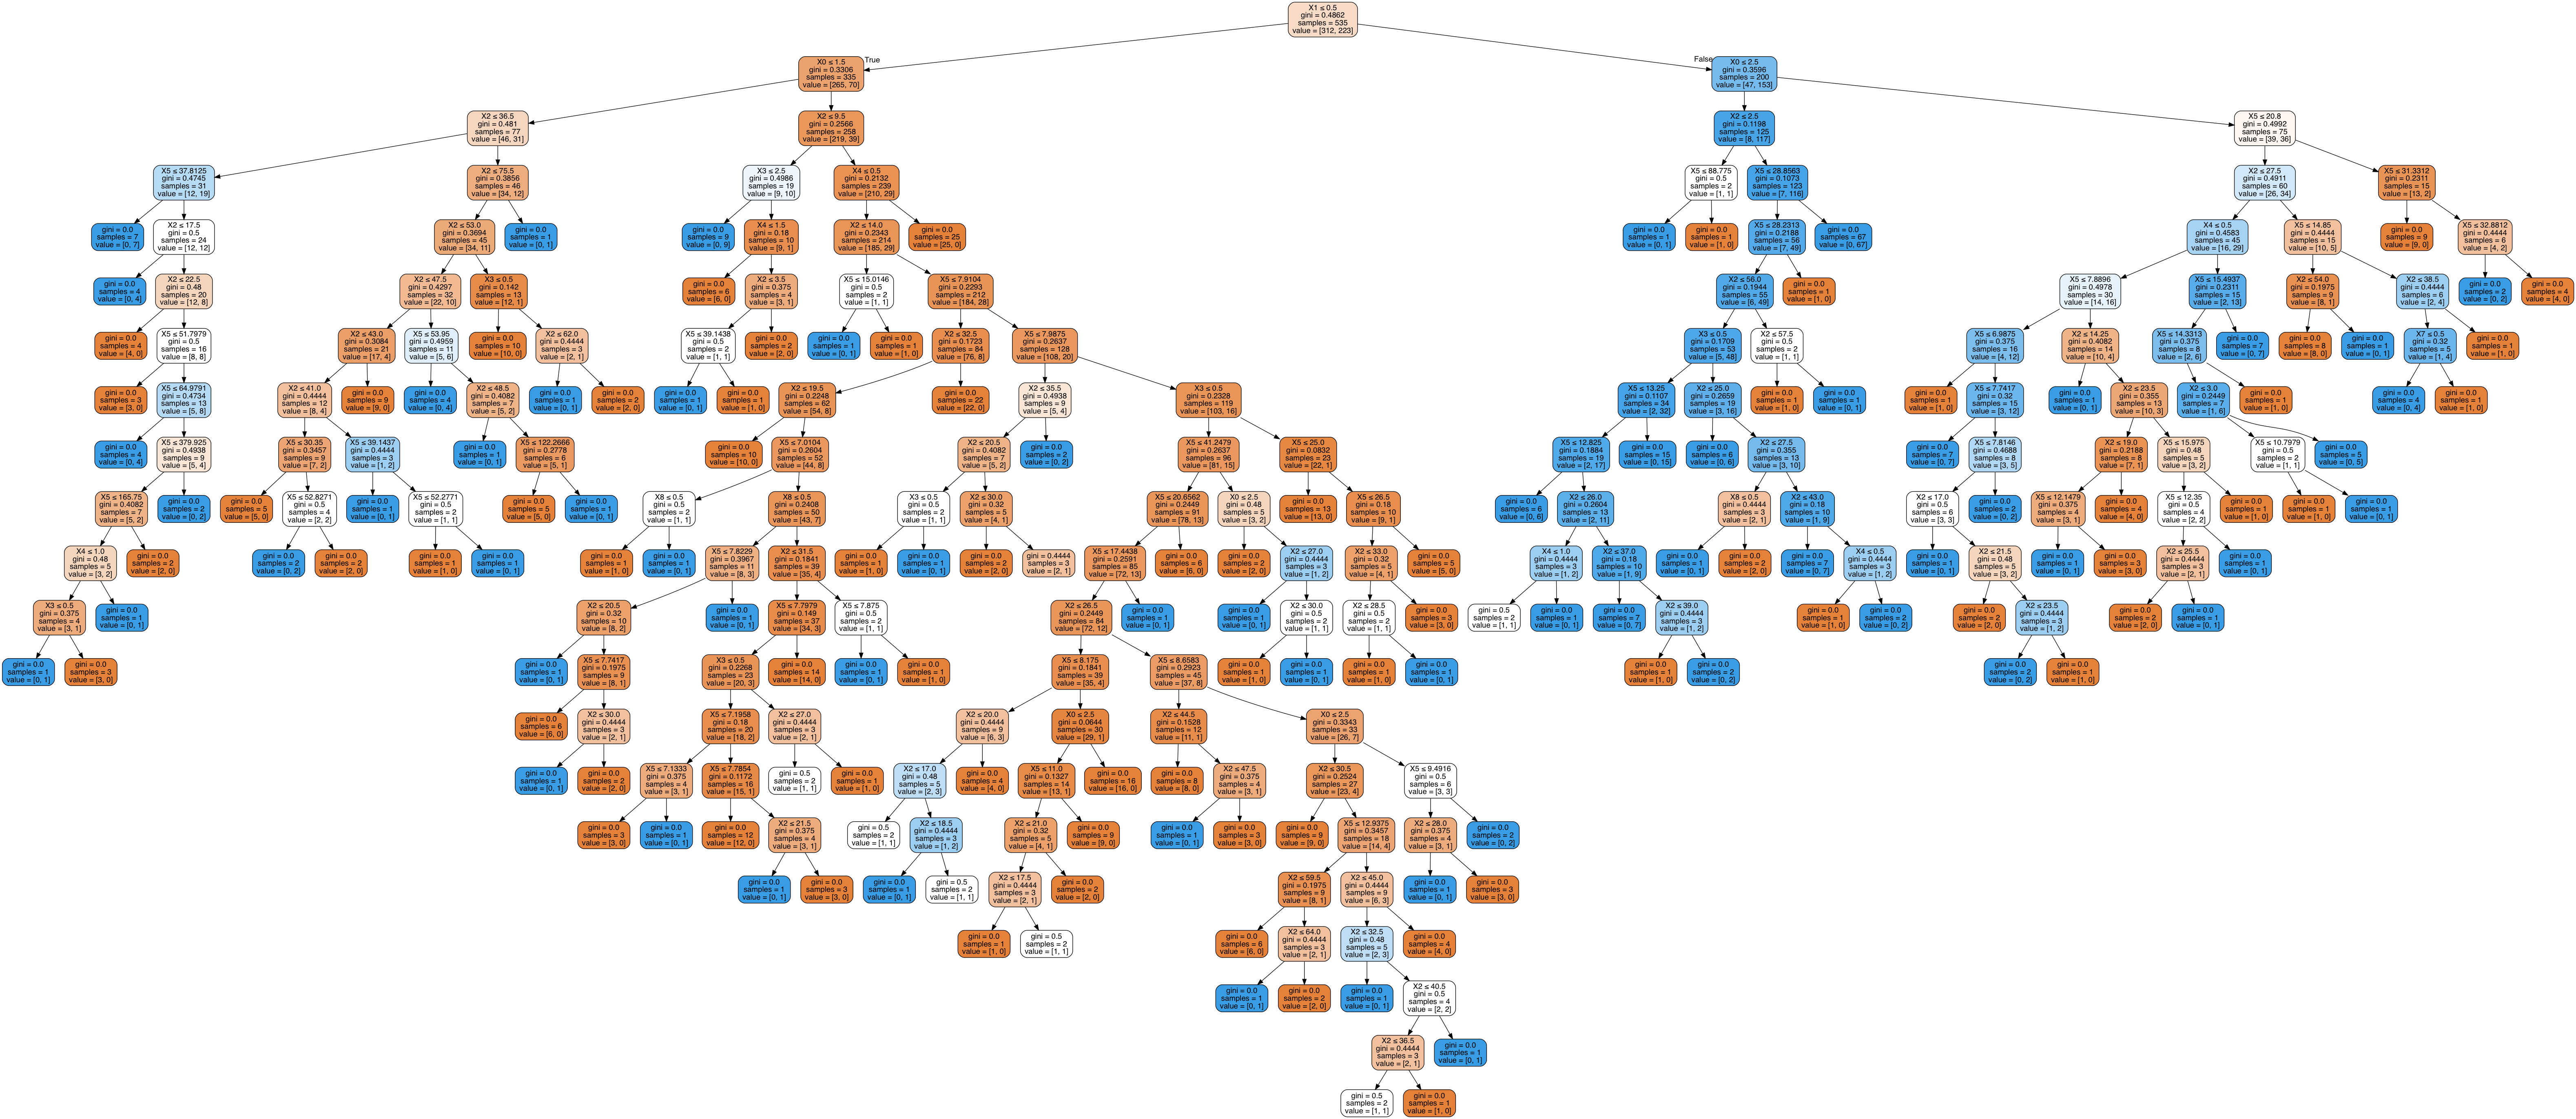

In [338]:
# thanks to https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [339]:
X_train.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C',
       'Embarked_Q', 'Embarked_S'],
      dtype='object')

The first branch in the tree is x1 less than/equal to 0.5. ie male/female. Next are Pclass and age

### Gradient Boosting

Lets see if gradient boosting improves upon the lone decision tree

In [340]:
from  sklearn.ensemble import GradientBoostingClassifier

In [341]:
gb=GradientBoostingClassifier()
gb=gb.fit(X_train,y_train)
gb.score(X_train,y_train)

0.90467289719626165

In [342]:
print(gb.score(X_test,y_test))
scores["gb"]=gb.score(X_test,y_test)*100

0.865921787709


# Summary of baseline models

In [343]:
scores

{'DT': 81.005586592178773,
 'GNB': 78.212290502793294,
 'LR': 78.770949720670387,
 'gb': 86.592178770949729}

# Engineering

## Overview

In [226]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null int64
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null float64
dtypes: float64(3), int64(6), object(3)
memory usage: 83.6+ KB


In [227]:
print("{} in the set, {} features in the training set, {} in the test set. {} features excluded".format(train.shape[0],y_train.shape[0],y_test.shape[0],(train.shape[0]-(y_train.shape[0]+y_test.shape[0]))))

891 in the set, 534 features in the training set, 178 in the test set. 179 features excluded


## Adding an _accompanied_ feature

The first feature I want to work on is whether someone is travelling alone or not. It seems to me that a child's survival chance will be improved if they are travelling with an adult, and vice versa, since we know history (and the movie _Titanic_ ;)) that women and children were evacuated on life boats.

In [344]:
train["Accompanied"]=train["Parch"] + train["SibSp"]

In [345]:
train['Accompanied'].loc[train['Accompanied'] > 0] = 1
train['Accompanied'].loc[train['Accompanied'] == 0] = 0


/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [346]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S,Accompanied
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,0,0,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,0,1,1
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,0,1,0


In [347]:
train.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Accompanied
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.352413,29.699118,0.523008,0.381594,32.204208,0.188552,0.086420,0.725028,0.397306
std,257.353842,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429,0.391372,0.281141,0.446751,0.489615
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,0.000000
50%,446.000000,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000,0.000000
75%,668.500000,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,0.000000,0.000000,1.000000,1.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000


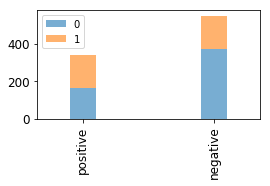

In [64]:
bar_by_feat(train,"Survived","Accompanied")

## Adding a _Family Size_ Feature

From the SibSp and Parch features, we can determine the size of the family, and how this influences survival 

In [348]:
train["FamSize"]=train["Parch"] + train["SibSp"] +1 

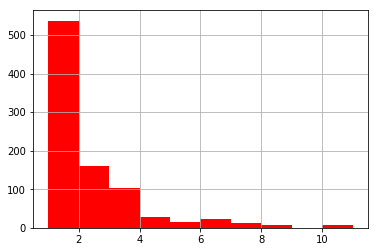

In [349]:
train["FamSize"].hist(color="red")
#train.loc[train["Survived"]==1,"FamSize"].hist(color="blue")
#train.loc[train["Survived"]==0,"FamSize"].hist(color="orange")

## Dealing with _Name_ feature

In [350]:
train["Name"].head(5)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

For the woman, their name is given in brackets, while the name of their husband is assigned after their title. Thus the data structure is for a male name is 

_lastname_, + _title_. + _firstname1_ + _firstname2_ ... 

and for a married female is 

_lastname_, + _title_. + _husbandfirstname1_ + _husbandfirstname2_ ... + _(first middle last)_

For example, in index 1, Mrs Futrelle is married to Jacques, and her first name is Lily and her maiden name is Peel:

In [351]:
train.loc[train["Name"].str.contains("(Futrelle)")]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S,Accompanied,FamSize
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1,C123,0,0,1,1,2
137,138,0,1,"Futrelle, Mr. Jacques Heath",0,37.0,1,0,113803,53.1,C123,0,0,1,1,2


The _Name_ feature has some useful imformation, most notably the title. This can help us in a number of ways. For example, we can determine if a woman is married and thus deconvolute the _SibSp_ feature. 

Lets check how many different titles we have in our dataset. We can do this using the map function, where we initially split the name using the comma as the delimiter. We can then split after the comma using the full stop as the delimiter to get the title

In [352]:
train['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip()).unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

Along with the commonplace _Mr_ and _Mrs_, we have some unusual titles such as _Major_, _Capt_, and _Jonkheer_, which is apparently a Dutch nobility title. First of all, lets create a married column 

In [353]:
train["Title"]=train['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip())

In [354]:
train["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [355]:
def married(title):
    MarriedWomanTitles=["Mrs","Lady","Sir","the Countess"]
    if title in MarriedWomanTitles:
        return 1
    else:
        return 0

In [356]:
train["MarriedWoman"]=train["Title"].apply(married)

In [357]:
train["MarriedWoman"].sum()

128

Now lets deal with the special, or noble, titles

In [358]:
def special(title):
    SpecialTitles=['Don', 'Rev', 'Dr','Major', 'Lady', 'Sir','Col', 'Capt', 'the Countess','Jonkheer']
    if title in SpecialTitles:
        return 1
    else:
        return 0

In [359]:
train["SpecialTitle"]=train["Title"].apply(special)

In [360]:
train["SpecialTitle"].sum()

23

In [361]:
train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S,Accompanied,FamSize,Title,MarriedWoman,SpecialTitle
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1,1,2,Mr,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,0,0,1,2,Mrs,1,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1,0,1,Miss,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,0,1,1,2,Mrs,1,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,0,1,0,1,Mr,0,0


## Filling in missing ages

In [362]:
print("There are {} missing ages.".format(train[train["Age"].isnull()].shape[0]))

There are 177 missing ages.


There are different ways to complete the ages. The easist is probably by just using the median age. However, this brute force approach is not particularly elegant and risks us losing a lot of resultion. Is there a more nuanced approach? For instance, we can further distill by using medians of the age if they are male or female, ticket class, fare price etc

In [33]:
train["Age"].median()

28.0

From our train subset, the decision tree classifier has gender as the first branch. So lets use that as a starting point for assigning the unknown ages

In [34]:
for s in train["Sex"].unique():
    print("Sex: {}: Median Age: {}".format(s,train.loc[train["Sex"]==s,"Age"].median()))

Sex: 0: Median Age: 29.0
Sex: 1: Median Age: 27.0


Lets look at how we can use the Pclass to further classify the age. Pclass is good becasue there are only 3 values

In [35]:
for pclass in train["Pclass"].unique():
    print("Class: {} Median Age: {}".format(pclass,train.loc[train["Pclass"]==pclass,"Age"].median()))

Class: 3 Median Age: 24.0
Class: 1 Median Age: 37.0
Class: 2 Median Age: 29.0


We can already see that people in class 1 are older than in class 3, which we can use to our advantage when assigning the new ages

How about we use a model to predict the unknown ages?

In [17]:
features.append("Accompanied")

In [36]:
features

['Survived',
 'Pclass',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Embarked',
 'Accompanied']

In [81]:
age_features=["Survived","Pclass","Sex","SibSp","Fare","Accompanied","Age"]

In [82]:
X=train[age_features].dropna().drop("Age",axis=1)
y=train[age_features].dropna()["Age"]
print(len(X),len(y))
print(y.mean())


714 714
29.6991176471


In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(len(y_train))
print(len(X_train))
print(len(y_test))
print(y_train.mean())
print(y_test.mean())
np.std(y_train)

535
535
179
29.8461121495
29.2597765363


14.492374218605294

In [84]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [85]:
Age_regr = LinearRegression()
Age_regr = Age_regr.fit(X,y)
Age_regr.score(X,y)

0.27159590631978414

In [86]:
age_pred=Age_regr.predict(X_train)

In [87]:
# The coefficients
print('Coefficients: \n', Age_regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_train, age_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_train, age_pred))


Coefficients: 
 [-6.77688241 -8.26634819  0.27554277 -3.63841623 -0.01640718 -1.85777337]
Mean squared error: 154.26
Variance score: 0.27


In [88]:
df=pd.DataFrame({"pred": age_pred,"actual":y_train})

In [89]:
meds=np.zeros(len(y_train))
meds=meds+29


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11674ac18>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1168435f8>]], dtype=object)

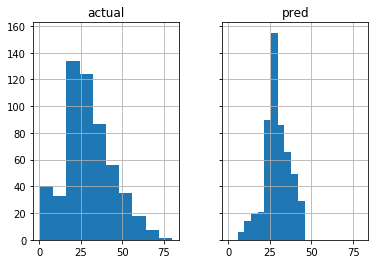

In [90]:
df.hist(sharex=True,sharey=True)

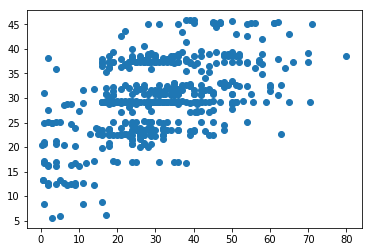

In [91]:
plt.scatter(y_train,age_pred)

Evidently, this rudimentary LR model for age prediction is poorly predicting the age data. However, it is still better than a brute fore assignment of the median age 

In [99]:
missing_age_indexes=train['Age'].index[train['Age'].apply(np.isnan)]
missing_age_indexes

Int64Index([  5,  17,  19,  26,  28,  29,  31,  32,  36,  42,
            ...
            832, 837, 839, 846, 849, 859, 863, 868, 878, 888],
           dtype='int64', length=177)

In [106]:
age_features=["Survived","Pclass","Sex","SibSp","Fare","Accompanied"]

In [112]:
new_ages=Age_regr.predict(train.loc[missing_age_indexes,age_features])

In [114]:
len(new_ages)

177

In [ ]:
###